In [1]:
import numpy as np
from navground import sim, core
from navground.sim.ui.video import display_video, display_video_from_run, record_video_from_run
from navground.sim.notebook import display_in_notebook
import matplotlib.pyplot as plt
import networkx as nx
from navground.sim.ui.render import png_for_world
from IPython.display import Image
from shapely.geometry import LineString, Point, Polygon, MultiPolygon
from shapely.ops import unary_union
import argparse
import pickle
sim.load_plugins()

In [2]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--agents', type=int, default=1, help='Number of agents')
parser.add_argument('--steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--optimal_speed', type=float, default=1.0, help='Optimal speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior_type', type=str, default='HL', help='Behavior type')

_StoreAction(option_strings=['--behavior_type'], dest='behavior_type', nargs=None, const=None, default='HL', type=<class 'str'>, choices=None, required=False, help='Behavior type', metavar=None)

In [3]:
args = parser.parse_args([
        '--runs', '100',
        '--agents', '5',
        '--steps', '1200',
        '--time_step', '0.1',
        '--max_speed', '1.66',
        '--optimal_speed', '1.2',
        '--radius', '0.4',
        '--safety_margin', '0.1',
        '--behavior_type', 'HL'
    ])

## Simulation without modulation

In [4]:
yaml_without = f"""
runs: {args.runs}
steps: {args.steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
record_efficacy: true
scenario:
  type: Home
  groups:
    -
      type: thymio
      number: {args.agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.01
      kinematics:
        type: 2WDiff
        wheel_axis: 0.6
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior_type}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment_without = sim.load_experiment(yaml_without)
experiment_without.run()
runs_without = experiment_without.runs

In [5]:
display_video_from_run(run=runs_without[0], factor=8.0, fps=30)

## Simulation with modulation

In [6]:
yaml_with = f"""
runs: {args.runs}
steps: {args.steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
record_efficacy: true
scenario:
  type: Home
  groups:
    -
      type: thymio
      number: {args.agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.01
      kinematics:
        type: 2WDiff
        wheel_axis: 0.6
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior_type}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
        modulations:
        - type: Graphs
          enabled: true
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment_with = sim.load_experiment(yaml_with)
experiment_with.run()
runs_with = experiment_with.runs

In [7]:
display_video_from_run(run=runs_with[0], factor=8.0, fps=30)

## Saving the results

In [8]:
with open("files/without.pkl", "wb") as file:
    pickle.dump(runs_without, file)
with open("files/with.pkl", "wb") as file:
    pickle.dump(runs_with, file)

## Metrics Comparison

### Collisions comparison

In [9]:
collisions_without = [len(run.collisions) for run in runs_without.values()]
np.mean(collisions_without)

np.float64(26.95)

In [10]:
collisions_with = [len(run.collisions) for run in runs_with.values()]
np.mean(collisions_with)

np.float64(17.57)

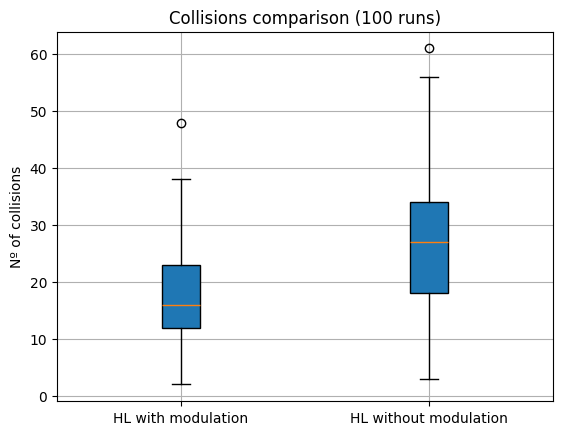

In [11]:
plt.boxplot([collisions_with, collisions_without], labels=['HL with modulation', 'HL without modulation'], patch_artist=True)
plt.title(f'Collisions comparison ({args.runs} runs)')
plt.ylabel('Nº of collisions')
plt.grid(True)
plt.savefig('plots/collisionscomparison.png')
plt.show()

### Deadlocks comparison

To compare deadlocks we need to create a new function. This is because when using the modulation, an agent that is waiting for another one to cross a narrow area can be counted as a deadlock when it is not really stuck.

In [12]:
def real_deadlocks(run):
    states = [agent.behavior.state for agent in run.world.agents]
    return np.array([run.deadlocks[i] if states[i] == 0 else -1 for i in range(len(states))])    

In [13]:
deadlocks_without = [sum(run.deadlocks>0) for run in runs_without.values()]
np.mean(deadlocks_without)

np.float64(1.51)

In [14]:
deadlocks_with = [sum(real_deadlocks(run)>0) for run in runs_with.values()]
np.mean(deadlocks_with)

np.float64(0.37)

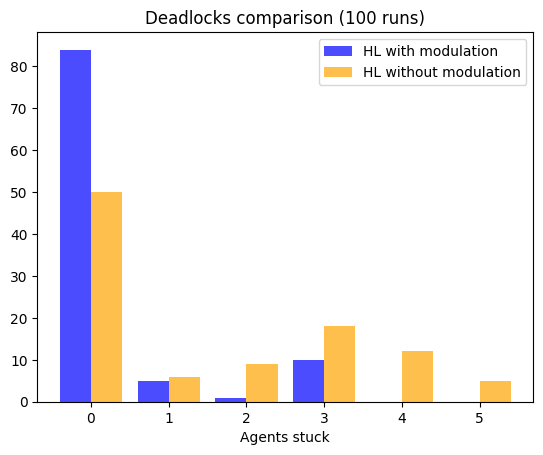

In [15]:
values = range(args.agents+1) 
freq_with = [deadlocks_with.count(v) for v in values]
freq_without = [deadlocks_without.count(v) for v in values]
x = np.arange(len(values))
width = 0.4
plt.bar(x - width/2, freq_with, width, label='HL with modulation', color='blue', alpha=0.7)
plt.bar(x + width/2, freq_without, width, label='HL without modulation', color='orange', alpha=0.7)
plt.xlabel('Agents stuck')
plt.ylabel('')
plt.title(f'Deadlocks comparison ({args.runs} runs)')
plt.xticks(x, values)  # Etiquetas de los valores
plt.legend()
plt.savefig('plots/deadlockscomparison.png')
plt.show()

### Efficacy comparison

When all the agents get stuck and the simulation stops early, we must fill the efficacy array with 0s.

In [16]:
efficacies_without = []
for run in runs_without.values():
    run_steps, agents = run.efficacy.shape
    if run_steps < args.steps:
        efficacies_without += [np.mean(np.vstack((run.efficacy, np.zeros((args.steps - run_steps, agents)))))]
    else:
        efficacies_without += [np.mean(run.efficacy)]
print(np.mean(efficacies_without))

0.24998576927762728


In [17]:
efficacies_with = []
for run in runs_with.values():
    run_steps, agents = run.efficacy.shape
    if run_steps < args.steps:
        efficacies_with += [np.mean(np.vstack((run.efficacy, np.zeros((args.steps - run_steps, agents)))))]
    else:
        efficacies_with += [np.mean(run.efficacy)]
print(np.mean(efficacies_with))

0.24969317


## Efficiency analysis

I want to store and analyse how much time does Navground need to compute my modulation.

In [18]:
for run in runs_with.values():
    run.world.agents

In [19]:
run = runs_with[0]

In [20]:
run.world.agents[4].behavior.time

0.0017037391662597656